## Logistic Regression

This notebook contains the logistic regression model we used to carry out classification.

In [60]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import geopandas as gpd

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)

In [61]:
# Set directory to Google Drive to get dataset
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ECO353')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Some Data Cleaning

In [62]:
df = pd.read_csv("prosperLoanData.csv")

In [63]:
category_mapping = {
    0: 'Not Available',
    1: 'Debt Consolidation',
    2: 'Home Improvement',
    3: 'Business',
    4: 'Personal Loan',
    5: 'Student Use',
    6: 'Auto',
    7: 'Other',
    8: 'Baby&Adoption',
    9: 'Boat',
    10: 'Cosmetic Procedure',
    11: 'Engagement Ring',
    12: 'Green Loans',
    13: 'Household Expenses',
    14: 'Large Purchases',
    15: 'Medical/Dental',
    16: 'Motorcycle',
    17: 'RV',
    18: 'Taxes',
    19: 'Vacation',
    20: 'Wedding Loans'
}

df['ListingCategory'] = df['ListingCategory (numeric)'].map(category_mapping)

In [64]:
df_filtered = df[["LoanStatus", "CreditGrade", "BorrowerRate", "ProsperScore",
                  "ListingCategory","Occupation","EmploymentStatus",
                  "IsBorrowerHomeowner", "IncomeVerifiable", "IncomeRange",
                  "LoanOriginalAmount", "Recommendations", "PercentFunded",
                  "CurrentDelinquencies" , "InquiriesLast6Months",
                  "PublicRecordsLast10Years"]] #"BorrowerState"
df_filtered = df_filtered[df_filtered['LoanStatus'].isin(['Completed', 'Defaulted'])]
df_filtered['Default'] = np.where(df_filtered['LoanStatus'] == 'Completed', 0, 1)

# Compute the percentage of missing values in the dataset.
count = df_filtered.isnull().sum()
percent = (df_filtered.isnull().sum()/43092)
missing_data = pd.concat([count, percent], axis=1, keys=['missing_count', 'missing_percent'])
missing_data.head(100)

,missing_count,missing_percent
LoanStatus,0,0.000000
CreditGrade,20794,0.482549
BorrowerRate,0,0.000000
ProsperScore,22423,0.520352
ListingCategory,0,0.000000
Occupation,1974,0.045809
EmploymentStatus,1961,0.045507
IsBorrowerHomeowner,0,0.000000
IncomeVerifiable,0,0.000000
IncomeRange,0,0.000000


In [65]:
df_filtered

,LoanStatus,CreditGrade,BorrowerRate,ProsperScore,ListingCategory,Occupation,EmploymentStatus,IsBorrowerHomeowner,IncomeVerifiable,IncomeRange,LoanOriginalAmount,Recommendations,PercentFunded,CurrentDelinquencies,InquiriesLast6Months,PublicRecordsLast10Years,Default
0,Completed,C,0.1580,NaN,Not Available,Other,Self-employed,True,True,"$25,000-49,999",9425,0,1.0,2.0,3.0,0.0,0
2,Completed,HR,0.2750,NaN,Not Available,Other,Not available,False,True,Not displayed,3001,0,1.0,1.0,0.0,0.0,0
11,Completed,C,0.1325,NaN,Not Available,Waiter/Waitress,Full-time,False,True,"$1-24,999",1000,0,1.0,3.0,3.0,0.0,0
15,Defaulted,NaN,0.3177,5.0,Household Expenses,Other,Other,True,True,"$50,000-74,999",4000,0,1.0,0.0,0.0,1.0,1
21,Completed,D,0.2075,NaN,Not Available,Professional,Full-time,False,True,"$25,000-49,999",3000,0,1.0,1.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113926,Defaulted,E,0.2900,NaN,Not Available,Other,Not available,False,True,Not displayed,3000,0,1.0,18.0,2.0,7.0,1
113927,Completed,AA,0.0679,NaN,Personal Loan,Executive,Full-time,True,True,"$100,000+",4292,2,1.0,0.0,1.0,0.0,0
113928,Completed,NaN,0.1899,6.0,Business,Other,Full-time,False,True,"$25,000-49,999",2000,0,1.0,0.0,0.0,0.0,0
113929,Completed,NaN,0.2639,3.0,Home Improvement,Accountant/CPA,Employed,False,True,"$50,000-74,999",2500,0,1.0,0.0,2.0,0.0,0


In [66]:
summary_table = df_filtered[["BorrowerRate", "ProsperScore",
                  "LoanOriginalAmount", "Recommendations",
                             "PercentFunded", "CurrentDelinquencies" ,
                             "InquiriesLast6Months",
                  "PublicRecordsLast10Years"]]
summary_table.describe()

,BorrowerRate,ProsperScore,LoanOriginalAmount,Recommendations,PercentFunded,CurrentDelinquencies,InquiriesLast6Months,PublicRecordsLast10Years
count,43092.000000,20669.000000,43092.000000,43092.000000,43092.000000,42472.000000,42472.000000,42472.000000
mean,0.190691,6.491944,6223.760582,0.090481,0.998767,0.772203,1.851173,0.296172
std,0.080835,2.307626,5182.542744,0.469887,0.016924,2.361499,2.828645,0.723141
min,0.000000,1.000000,1000.000000,0.000000,0.700000,0.000000,0.000000,0.000000
25%,0.123000,5.000000,2550.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.180000,7.000000,4500.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,0.257600,8.000000,8000.000000,0.000000,1.000000,0.000000,2.000000,0.000000
max,0.497500,11.000000,35000.000000,39.000000,1.011000,83.000000,63.000000,22.000000


CreditGrade: The Credit rating that was assigned at the time the listing went live. Applicable for listings pre-2009 period and will only be populated for those listings;

ProsperScore: A custom risk score built using historical Prosper data. The score ranges from 1-10, with 10 being the best, or lowest risk score. Applicable for loans originated after July 2009.

In [67]:
# Creidt grade - omitted: NC
df_filtered['creditgrade_AA'] = np.where(df_filtered['CreditGrade'] == 'AA', 1, 0)
df_filtered['creditgrade_A'] = np.where(df_filtered['CreditGrade'] == 'A', 1, 0)
df_filtered['creditgrade_B'] = np.where(df_filtered['CreditGrade'] == 'B', 1, 0)
df_filtered['creditgrade_C'] = np.where(df_filtered['CreditGrade'] == 'C', 1, 0)
df_filtered['creditgrade_D'] = np.where(df_filtered['CreditGrade'] == 'D', 1, 0)
df_filtered['creditgrade_E'] = np.where(df_filtered['CreditGrade'] == 'E', 1, 0)
df_filtered['creditgrade_HR'] = np.where(df_filtered['CreditGrade'] == 'HR', 1, 0)

# Income range - omitted: Not displayed
df_filtered['no_income'] = np.where(df_filtered['IncomeRange'].isin(['$0', 'Not employed']), 1, 0)
df_filtered['income_below25k'] = np.where(df_filtered['IncomeRange'] == '$1-24,999', 1, 0)
df_filtered['income_25k_50k'] = np.where(df_filtered['IncomeRange'] == '$25,000-49,999', 1, 0)
df_filtered['income_50k_75k'] = np.where(df_filtered['IncomeRange'] == '$50,000-74,999', 1, 0)
df_filtered['income_75k_100k'] = np.where(df_filtered['IncomeRange'] == '$75,000-99,999', 1, 0)
df_filtered['income_greater100k'] = np.where(df_filtered['IncomeRange'] == '$100,000+', 1, 0)

# Homeowner - ommited: No
df_filtered['is_homeowner'] = np.where(df_filtered['IsBorrowerHomeowner'] == 'True', 1, 0)

# Income verifiable - omitted: No
df_filtered['income_verifiable'] = np.where(df_filtered['IncomeVerifiable'] == 'True', 1, 0)

In [68]:
# Create the dummy for students
students = ['Student - College Senior', 'Student - College Graduate Student',
                       'Student - Technical School', 'Student - College Junior',
                       'Student - Community College', 'Student - College Freshman',
                       'Student - College Sophomore']

df_filtered['is_student'] = np.where(df_filtered['Occupation'].isin(students), 1, 0)

In [69]:
# Re-categorize the employment status
def categorize_employment(status):
    if status in ['Employed', 'Full-time', 'Part-time', 'Self-employed']:
        return 'Yes'
    elif status in ['Not employed', 'Retired']:
        return 'No'
    else:
        return 'Not Available or Others'

df_filtered['Employment'] = df_filtered['EmploymentStatus'].apply(categorize_employment)

# Employment status - omitted: Not Available or Others
df_filtered['employment_yes'] = np.where(df_filtered['Employment'] == 'True', 1, 0)
df_filtered['employment_no'] = np.where(df_filtered['Employment'] == 'No', 1, 0)

In [70]:
# Re-categorize the listing category status
def categorize_listing(category):
    if category in ['Not Available']:
        return 'No'
    else:
        return 'Yes'

df_filtered['ReportedLoanPurpose'] = df_filtered['ListingCategory'].apply(categorize_listing)

# Reported purpose - omitted: No (NOT reported)
df_filtered['reported_purpose'] = np.where(df_filtered['ReportedLoanPurpose'] == 'Yes', 1, 0)

In [71]:
# Drop original, uncleaned columns
df_filtered = df_filtered.drop(columns = ['LoanStatus', 'CreditGrade', 'IsBorrowerHomeowner', 'Occupation', 'EmploymentStatus', 'Employment', 'ListingCategory', 'IncomeRange', 'IncomeVerifiable', 'ReportedLoanPurpose'])

## Missing data imputation

In [72]:
# Normalize data before KNN imputation - otherwise the difference in scales of each prediction may lead to biased imputed values
scaler = MinMaxScaler()
df_filtered = pd.DataFrame(scaler.fit_transform(df_filtered), columns = df_filtered.columns)

In [73]:
# KNN imputation - fill in each missing value by using values of its 5 nearest neighbors (with smallest euclidean distances), uniformly weighted
imputer = KNNImputer(n_neighbors=5, weights="uniform")
X_imputed = imputer.fit_transform(df_filtered.drop(columns=['Default']))

# Convert the imputed array back to a dataframe, since the state and year dummies will be added later
X_imputed_df = pd.DataFrame(X_imputed, columns=df_filtered.drop(columns=['Default']).columns)

In [74]:
# Add dummies for fixed effects
df = df[df['LoanStatus'].isin(['Completed', 'Defaulted'])]
df["Year"] = pd.to_datetime(df['ListingCreationDate'], format = 'mixed').dt.year
temp = df[["Year", "BorrowerState"]]
temp = temp.reset_index(drop=True)

X_imputed_df = pd.concat([X_imputed_df, temp], axis=1)
X_imputed_df["BorrowerState"].fillna("Unknown", inplace=True)

year_dummies = pd.get_dummies(X_imputed_df["Year"], prefix="Year", drop_first=True)
state_dummies = pd.get_dummies(X_imputed_df["BorrowerState"], prefix="State", drop_first=True)
X_imputed_df = pd.concat([X_imputed_df, year_dummies, state_dummies], axis=1)
X_imputed_df.drop(columns=['Year', 'BorrowerState'], inplace=True)
X_imputed_df

<ipython-input-74-bb31209eb817>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Year"] = pd.to_datetime(df['ListingCreationDate'], format = 'mixed').dt.year


,BorrowerRate,ProsperScore,LoanOriginalAmount,Recommendations,PercentFunded,CurrentDelinquencies,InquiriesLast6Months,PublicRecordsLast10Years,creditgrade_AA,creditgrade_A,creditgrade_B,creditgrade_C,creditgrade_D,creditgrade_E,creditgrade_HR,no_income,income_below25k,income_25k_50k,income_50k_75k,income_75k_100k,income_greater100k,is_homeowner,income_verifiable,is_student,employment_yes,employment_no,reported_purpose,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_Unknown,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,0.317588,0.52,0.247794,0.000000,0.96463,0.024096,0.047619,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0.552764,0.50,0.058853,0.000000,0.96463,0.012048,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0.266332,0.60,0.000000,0.000000,0.96463,0.036145,0.047619,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
3,0.638593,0.40,0.088235,0.000000,0.96463,0.000000,0.000000,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,0.417085,0.58,0.058824,0.000000,0.96463,0.012048,0.000000,0.045455,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43087,0.582915,0.50,0.058824,0.000000,0.96463,0.216867,0.031746,0.318182,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,Fal

## Split data into training and testing sets

In [75]:
# Separate features and target variables
X = X_imputed_df
y = df_filtered['Default']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1006693712)

In [278]:
# Download training data, just in case of using other softwares to do analysis
from google.colab import files
# Produce the dataset
output_df = pd.merge(X_train, y_train, left_index = True, right_index = True).sort_index()
path = '/content/drive/MyDrive/Colab Notebooks/ECO353/training_set.csv'
output_df.to_csv(path, index=False)
files.download('/content/drive/MyDrive/Colab Notebooks/ECO353/training_set.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Variable Selection by Stepwise AIC

In [82]:
# Note: This chunk takes around 10 mins to run. To save time, skip this chunk.
model_logistic = LogisticRegression(max_iter=1000)

# Stepwise feature selection
stepwise_selection = SequentialFeatureSelector(model_logistic, n_features_to_select=15, direction='forward', cv=5)
stepwise_selection.fit(X_train, y_train)

# Print the selected features
stepwise_features = X.columns[stepwise_selection.get_support(indices=True)]
print("Features determined by forward stepwise selection:", stepwise_features)

Features determined by forward stepwise selection: Index(['BorrowerRate', 'ProsperScore', 'CurrentDelinquencies',
       'InquiriesLast6Months', 'creditgrade_AA', 'creditgrade_HR',
       'income_75k_100k', 'reported_purpose', 'Year_2006', 'State_ID',
       'State_MA', 'State_MI', 'State_NC', 'State_NY', 'State_Unknown'],
      dtype='object')


## Logistic Model fitting without regularization

---



In [77]:
# Run this chunk instead the last chunk to save time
# Note that we set penalty = none to not induce regularization
model_logistic = LogisticRegression(max_iter=1000, penalty = None)
stepwise_features = ['BorrowerRate', 'ProsperScore', 'CurrentDelinquencies',
       'InquiriesLast6Months', 'creditgrade_AA', 'creditgrade_HR',
       'income_75k_100k', 'reported_purpose', 'Year_2006', 'State_ID',
       'State_MA', 'State_MI', 'State_NC', 'State_NY', 'State_Unknown']

In [78]:
# Keep predictor variables selected by the stepwise selection
X_stepwise = X[stepwise_features]

# Split the data into training and testing sets
X_stepwise_train, X_stepwise_test, y_stepwise_train, y_stepwise_test = train_test_split(X_stepwise, y, test_size=0.25, random_state=1006693712)

# Fit a logistic regression using features selected by forward stepwise selection
model_logistic.fit(X_stepwise_train, y_stepwise_train)

# Predict on the test set
y_stepwise_pred = model_logistic.predict(X_stepwise_test)

# Calculate the accuracy score
accuracy_stepwise = accuracy_score(y_stepwise_test, y_stepwise_pred)
print("The prediction accuracy by the logistic regression model with predictors selected by stepwise selection:", accuracy_stepwise)

The prediction accuracy by the logistic regression model with predictors selected by stepwise selection: 0.9006776199758656


In [79]:
from sklearn.metrics import classification_report, confusion_matrix
conf_matrix = confusion_matrix(y_stepwise_test, y_stepwise_pred)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[9506   84]
 [ 986  197]]


### Re-fit using statsmodel to get summary table

In [80]:
import statsmodels.api as sm

X_stepwise_train_sm = sm.add_constant(X_stepwise_train)  # adding a constant for the intercept

# Convert some columns from boolean to float
X_stepwise_train_sm = X_stepwise_train_sm.apply(lambda x: x.astype(int) if x.dtype == bool else x)

# Note that this logistic regression does not include L2 regularization
model = sm.Logit(y_stepwise_train, X_stepwise_train_sm)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.308536
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                32319
Model:                          Logit   Df Residuals:                    32303
Method:                           MLE   Df Model:                           15
Date:                Sat, 13 Apr 2024   Pseudo R-squ.:                  0.1530
Time:                        01:27:27   Log-Likelihood:                -9971.6
converged:                       True   LL-Null:                       -11772.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.9196      0.145    -20.145      0.000      -3.204      -2.636

In [86]:
# Convert to a nice looking table
summary_df = pd.DataFrame({
    'Coefficient': result.params,
    'Std. Error': result.bse,
    'z': result.tvalues,
    'P>|z|': result.pvalues,
    'Conf. Interval Lower': result.conf_int()[0],
    'Conf. Interval Upper': result.conf_int()[1]
})

# Round to 4 digits
formatted_summary_df = summary_df.applymap(lambda x: f'{x:.4f}')
formatted_summary_df['P>|z|'] = summary_df['P>|z|'].apply(lambda x: f'{x:.4e}')

display(formatted_summary_df)

,Coefficient,Std. Error,z,P>|z|,Conf. Interval Lower,Conf. Interval Upper
const,-2.9196,0.1449,-20.1447,2.9945e-90,-3.2037,-2.6356
BorrowerRate,3.0457,0.1771,17.1929,3.0015e-66,2.6985,3.3929
ProsperScore,0.3227,0.1530,2.1088,3.4965e-02,0.0228,0.6227
CurrentDelinquencies,5.5782,0.5490,10.1605,2.9758e-24,4.5021,6.6542
InquiriesLast6Months,5.9320,0.3624,16.3678,3.2456e-60,5.2217,6.6424
creditgrade_AA,-0.1592,0.0919,-1.7315,8.3370e-02,-0.3393,0.0210
creditgrade_HR,0.3658,0.0662,5.5297,3.2079e-08,0.2362,0.4955
income_75k_100k,-0.1951,0.0676,-2.8876,3.8818e-03,-0.3275,-0.0627
reported_purpose,-1.2754,0.0499,-25.5428,6.5930e-144,-1.3732,-1.1775
Year_2006,0.5742,0.0565,10.1551,3.1463e-24,0.4634,0.6850


In [26]:
# Compare with model fitted by sklearn. Difference acceptable.
print(model_logistic.intercept_)
print(model_logistic.coef_)

[-2.91923292]
[[ 3.04511582  0.32256256  5.56984921  5.93376403 -0.15958145  0.36601808
  -0.19533827 -1.27534931  0.57427147  0.02574944 -0.46744525 -0.03961109
  -0.37888581 -0.50700346 -1.22100401]]


## Logistic Model fitting with L2 Regularization (Ridge Regression)

In [27]:
# Run this chunk instead the last chunk to save time
# Note that the default sklearn.LogisticRegression uses L2 penalty to avoid overfitting
model_logistic_l2 = LogisticRegression(max_iter=1000)

In [28]:
# Keep predictor variables selected by the stepwise selection
X_stepwise = X[stepwise_features]

# Split the data into training and testing sets
X_stepwise_train, X_stepwise_test, y_stepwise_train, y_stepwise_test = train_test_split(X_stepwise, y, test_size=0.25, random_state=1006693712)

# Fit a logistic regression using features selected by forward stepwise selection
model_logistic_l2.fit(X_stepwise_train, y_stepwise_train)

# Predict on the test set
y_stepwise_pred_l2 = model_logistic_l2.predict(X_stepwise_test)

# Calculate the accuracy score
accuracy_stepwise = accuracy_score(y_stepwise_test, y_stepwise_pred_l2)
print("The prediction accuracy by the logistic regression model with predictors selected by stepwise selection:", accuracy_stepwise)

The prediction accuracy by the logistic regression model with predictors selected by stepwise selection: 0.9002134967047247


In [29]:
conf_matrix = confusion_matrix(y_stepwise_test, y_stepwise_pred_l2)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[9513   77]
 [ 998  185]]


### Logistic Model Interpretation of Coefficients

First, convert the variables back to the original scale before min-max transformation to make interpretation more straight forward.

In [257]:
# Find the indices of each element in stepwise features based on their position in scaler transformation
indices = [np.where(scaler.feature_names_in_ == item)[0][0] for item in stepwise_features if item in scaler.feature_names_in_]
indices

[0, 1, 5, 6, 9, 15, 20, 27]

In [284]:
# Retrieve scaled coefficients
beta_scaled = model_logistic.coef_[0]
intercept_scaled = model_logistic.intercept_[0]
# Rescaling coefficients back to original scale
#range_X = pd.DataFrame(scaler.data_max_ - scaler.data_min_, columns = df_filtered.columns)
range_X = scaler.data_max_[indices] - scaler.data_min_[indices]  # Range of each feature
beta_original = beta_scaled[0:8].flatten() * range_X
beta_original = np.concatenate((beta_original, beta_scaled[8:]))

pd.DataFrame(scaler.fit_transform(df_filtered), columns = df_filtered.columns)

# Adjusting the intercept
intercept_original = intercept_scaled - np.sum((beta_scaled[0:8].flatten() * scaler.data_min_[indices]) / range_X)

Original Coefficients: [ 1.49131585e+00  2.08065069e+00  3.57476684e+02  3.28720384e+02
 -1.81424508e-01  4.30425308e-01 -1.87685397e-01 -1.30267627e+00
  5.86322543e-01  3.10700291e-02 -4.54796219e-01 -3.47928959e-02
 -3.72138496e-01 -5.04083937e-01 -1.20199300e+00]
Original Intercept: -2.7844994984577816


In [287]:
# Output the transformed coefficients and intercept
np.set_printoptions(precision=3, suppress=True)
print("Original Coefficients:", beta_original)
print("Original Intercept:", intercept_original)

Original Coefficients: [  1.491   2.081 357.477 328.72   -0.181   0.43   -0.188  -1.303   0.586
   0.031  -0.455  -0.035  -0.372  -0.504  -1.202]
Original Intercept: -2.7844994984577816


In [290]:
# Create a DataFrame linking feature names with their coefficients
coef_table = pd.DataFrame({
    'Feature': stepwise_features,
    'Coefficient': beta_original
})
coef_table

,Feature,Coefficient
0,BorrowerRate,1.491316
1,ProsperScore,2.080651
2,CurrentDelinquencies,357.476684
3,InquiriesLast6Months,328.720384
4,creditgrade_AA,-0.181425
5,creditgrade_HR,0.430425
6,income_75k_100k,-0.187685
7,reported_purpose,-1.302676
8,Year_2006,0.586323
9,State_ID,0.031070


## Attach payoff variables

In [30]:
additional_df1 = df_filtered[["LoanOriginalAmount","Default"]]
# get some additional variables and center them
additional_df2 = df[(df["LoanStatus"] == "Completed") | (df["LoanStatus"] == "Defaulted")]
additional_df2 = additional_df2.reset_index(drop=True)
additional_df2 = additional_df2[["LoanOriginalAmount", "BorrowerRate", "LP_InterestandFees", "LP_GrossPrincipalLoss"]]
additional_df2 = additional_df2.rename(columns={'LoanOriginalAmount': 'RealLoanOriginalAmount', 'BorrowerRate': 'RealBorrowerRate'})
#scaler = MinMaxScaler()
#additional_df = pd.DataFrame(scaler.fit_transform(additional_df), columns = additional_df.columns)
# Sort the index of training set
X_stepwise_train = X_stepwise_train.sort_index()
training_df = pd.merge(left = X_stepwise_train, right = additional_df1, how = 'left', left_index=True, right_index=True)
training_df = pd.merge(left = training_df, right = additional_df2, how = 'left', left_index=True, right_index=True)
training_df

,BorrowerRate,ProsperScore,CurrentDelinquencies,InquiriesLast6Months,creditgrade_AA,creditgrade_HR,income_75k_100k,reported_purpose,Year_2006,State_ID,State_MA,State_MI,State_NC,State_NY,State_Unknown,LoanOriginalAmount,Default,RealLoanOriginalAmount,RealBorrowerRate,LP_InterestandFees,LP_GrossPrincipalLoss
0,0.317588,0.52,0.024096,0.047619,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,0.247794,0.0,9425,0.1580,1971.14,0.00
1,0.552764,0.50,0.012048,0.000000,0.0,1.0,0.0,0.0,False,False,False,False,False,False,False,0.058853,0.0,3001,0.2750,1185.63,0.00
2,0.266332,0.60,0.036145,0.047619,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,0.000000,0.0,1000,0.1325,11.65,0.00
3,0.638593,0.40,0.000000,0.000000,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.088235,1.0,4000,0.3177,311.38,3790.25
4,0.417085,0.58,0.012048,0.000000,0.0,0.0,0.0,0.0,False,False,False,True,False,False,False,0.058824,0.0,3000,0.2075,1061.05,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43086,0.419899,0.54,0.000000,0.015873,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.205882,0.0,8000,0.2089,2830.40,0.00
43087,0.582915,0.50,0.216867,0.031746,0.0,0.0,0.0,0.0,True,False,False,False,False,False,False,0.058824,1.0,3000,0.2900,541.86,2536.11
43088,0.136482,0.88,0.000000,0.015873,1.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.096824,0.0,4292,0.0679,464.93,0.00
43089,0.381709,0.50,0.000000,0.000000,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.029412,0.0,2000,0.1899,83.62,0.00


In [31]:
# Generate variables for payoffs
training_df['payoff_TN'] = training_df["RealLoanOriginalAmount"]*(training_df["RealBorrowerRate"])
training_df['payoff_FN'] = -(training_df["LP_GrossPrincipalLoss"] + \
 (training_df["RealLoanOriginalAmount"]*(training_df["RealBorrowerRate"]) - \
  training_df["LP_InterestandFees"]))
training_df['payoff_FP'] = 0
training_df['payoff_TP'] = 0
training_df

,BorrowerRate,ProsperScore,CurrentDelinquencies,InquiriesLast6Months,creditgrade_AA,creditgrade_HR,income_75k_100k,reported_purpose,Year_2006,State_ID,State_MA,State_MI,State_NC,State_NY,State_Unknown,LoanOriginalAmount,Default,RealLoanOriginalAmount,RealBorrowerRate,LP_InterestandFees,LP_GrossPrincipalLoss,payoff_TN,payoff_FN,payoff_FP,payoff_TP
0,0.317588,0.52,0.024096,0.047619,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,0.247794,0.0,9425,0.1580,1971.14,0.00,1489.1500,481.9900,0,0
1,0.552764,0.50,0.012048,0.000000,0.0,1.0,0.0,0.0,False,False,False,False,False,False,False,0.058853,0.0,3001,0.2750,1185.63,0.00,825.2750,360.3550,0,0
2,0.266332,0.60,0.036145,0.047619,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,0.000000,0.0,1000,0.1325,11.65,0.00,132.5000,-120.8500,0,0
3,0.638593,0.40,0.000000,0.000000,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.088235,1.0,4000,0.3177,311.38,3790.25,1270.8000,-4749.6700,0,0
4,0.417085,0.58,0.012048,0.000000,0.0,0.0,0.0,0.0,False,False,False,True,False,False,False,0.058824,0.0,3000,0.2075,1061.05,0.00,622.5000,438.5500,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43086,0.419899,0.54,0.000000,0.015873,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.205882,0.0,8000,0.2089,2830.40,0.00,1671.2000,1159.2000,0,0
43087,0.582915,0.50,0.216867,0.031746,0.0,0.0,0.0,0.0,True,False,False,False,False,False,False,0.058824,1.0,3000,0.2900,541.86,2536.11,870.0000,-2864.2500,0,0
43088,0.136482,0.88,0.000000,0.015873,1.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.096824,0.0,4292,0.0679,464.93,0.00,291.4268,173.5032,0,0
43089,0.381709,0.50,0.000000,0.000000,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.029412,0.0,2000,0.1899,83.62,0.00,379.8000,-296.1800,0,0


In [32]:
# Obtain testing df with additional variables
X_stepwise_test = X_stepwise_test.sort_index()
testing_df = pd.merge(left = X_stepwise_test, right = additional_df1, how = 'left', left_index=True, right_index=True)
testing_df = pd.merge(left = testing_df, right = additional_df2, how = 'left', left_index=True, right_index=True)
# Generate variables for payoffs
testing_df['payoff_TN'] = testing_df["RealLoanOriginalAmount"]*(testing_df["RealBorrowerRate"])
testing_df['payoff_FN'] = -(testing_df["LP_GrossPrincipalLoss"] + \
 (testing_df["RealLoanOriginalAmount"]*(testing_df["RealBorrowerRate"]) - \
  testing_df["LP_InterestandFees"]))
testing_df['payoff_FP'] = 0
testing_df['payoff_TP'] = 0
testing_df
#testing_df[testing_df['Default'] == 1]

,BorrowerRate,ProsperScore,CurrentDelinquencies,InquiriesLast6Months,creditgrade_AA,creditgrade_HR,income_75k_100k,reported_purpose,Year_2006,State_ID,State_MA,State_MI,State_NC,State_NY,State_Unknown,LoanOriginalAmount,Default,RealLoanOriginalAmount,RealBorrowerRate,LP_InterestandFees,LP_GrossPrincipalLoss,payoff_TN,payoff_FN,payoff_FP,payoff_TP
6,0.564623,0.20,0.000000,0.031746,0.0,0.0,0.0,1.0,False,False,False,False,False,True,False,0.088235,0.0,4000,0.2809,725.35,0.0,1123.60,-398.25,0,0
8,0.200804,0.80,0.012048,0.000000,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.264706,0.0,10000,0.0999,686.32,0.0,999.00,-312.68,0,0
12,0.321608,0.52,0.000000,0.031746,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,0.176471,0.0,7000,0.1600,1861.43,0.0,1120.00,741.43,0,0
16,0.395980,0.66,0.012048,0.000000,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,0.000000,0.0,1000,0.1970,294.98,0.0,197.00,97.98,0,0
18,0.502513,0.56,0.036145,0.000000,0.0,0.0,0.0,0.0,True,False,False,False,False,False,False,0.035294,0.0,2200,0.2500,511.61,0.0,550.00,-38.39,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43075,0.278392,0.70,0.000000,0.000000,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.102941,0.0,4500,0.1385,1024.18,0.0,623.25,400.93,0,0
43082,0.402010,0.48,0.012048,0.079365,0.0,0.0,0.0,1.0,False,False,True,False,False,False,False,0.058824,0.0,3000,0.2000,1064.13,0.0,600.00,464.13,0,0
43084,0.080402,0.60,0.002410,0.003175,1.0,0.0,0.0,0.0,False,False,False,False,False,False,True,0.000000,0.0,1000,0.0400,0.89,0.0,40.00,-39.11,0,0
43085,0.260302,0.76,0.000000,0.000000,0.0,0.0,0.0,1.0,False,False,False,False,False,False,False,0.117647,0.0,5000,0.1295,1061.29,0.0,647.50,413.79,0,0


In [33]:
# Calculate expected payoff for the logistic model without regularization
actual = testing_df["Default"]
N = len(testing_df)
predicted_test_logistic = y_stepwise_pred
# Calculate expected payoff
TP = (predicted_test_logistic == 1) & (actual == 1)
TN = (predicted_test_logistic == 0) & (actual == 0)
FP = (predicted_test_logistic == 1) & (actual == 0)
FN = (predicted_test_logistic == 0) & (actual == 1)
payoff_logistic_default = np.sum(testing_df['payoff_TP'][TP]) + \
     np.sum(testing_df['payoff_TN'][TN]) + \
     np.sum(testing_df['payoff_FP'][FP]) + \
     np.sum(testing_df['payoff_FN'][FN])


print(f"Optimal Payoff: {payoff_logistic_default/N}")

Optimal Payoff: 402.91621940963535


In [34]:
# Calculate expected payoff for the logistic model with L2 regularization
actual = testing_df["Default"]
N = len(testing_df)
predicted_test_logistic_l2 = y_stepwise_pred_l2
# Calculate expected payoff
TP = (predicted_test_logistic_l2 == 1) & (actual == 1)
TN = (predicted_test_logistic_l2 == 0) & (actual == 0)
FP = (predicted_test_logistic_l2 == 1) & (actual == 0)
FN = (predicted_test_logistic_l2 == 0) & (actual == 1)
payoff_logistic_default = np.sum(testing_df['payoff_TP'][TP]) + \
     np.sum(testing_df['payoff_TN'][TN]) + \
     np.sum(testing_df['payoff_FP'][FP]) + \
     np.sum(testing_df['payoff_FN'][FN])


print(f"Optimal Payoff: {payoff_logistic_default/N}")

Optimal Payoff: 405.52825746774363


## Tuning Logistic Model without Regularization to Maximize Payoff

In [35]:
# Prediction
probabilities_logistic = model_logistic.predict_proba(X_stepwise_train)[:, 1]  # Get the probability of the positive class

(array([20751.,  7262.,  1967.,   862.,   592.,   382.,   248.,   164.,
           65.,    26.]),
 array([0.00635751, 0.10559929, 0.20484108, 0.30408287, 0.40332466,
        0.50256645, 0.60180823, 0.70105002, 0.80029181, 0.8995336 ,
        0.99877539]),
 <BarContainer object of 10 artists>)

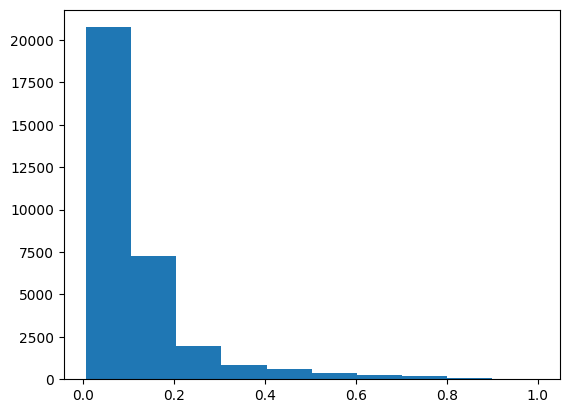

In [36]:
# Check the distribution of predicted probabilities.
plt.hist(probabilities_logistic)

In [39]:
# Find optimal threshold for logistic regression
N = len(training_df)
thresholds = np.linspace(0, 1, 101)  # Define a range of possible thresholds
optimal_payoff = -np.inf
optimal_threshold_logistic = None
actual = training_df["Default"]

for threshold in thresholds:
    # Vectorized calculation of classifications based on the current threshold
    predictions = (probabilities_logistic > threshold).astype(float)

    # Vectorized calculation of payoffs
    TP = (predictions == 1) & (actual == 1)
    TN = (predictions == 0) & (actual == 0)
    FP = (predictions == 1) & (actual == 0)
    FN = (predictions == 0) & (actual == 1)

    # Calculate total expected payoff for the current threshold
    current_payoff = np.sum(training_df['payoff_TP'][TP]) + \
     np.sum(training_df['payoff_TN'][TN]) + \
     np.sum(training_df['payoff_FP'][FP]) + \
     np.sum(training_df['payoff_FN'][FN])

    # Update optimal threshold if the current threshold yields a higher payoff
    if current_payoff > optimal_payoff:
        optimal_payoff = current_payoff
        optimal_threshold_logistic = threshold

print(f"Optimal Threshold: {optimal_threshold_logistic}, Optimal Payoff: {optimal_payoff/N}")

Optimal Threshold: 0.18, Optimal Payoff: 513.9841332683562


In [41]:
# Prediction to the testing set
probabilities_logistic_test = model_logistic.predict_proba(X_stepwise_test)[:, 1]  # Get the probability of the positive class
# Use the threshold from training set to carry out classification
predicted_test_logistic = (probabilities_logistic_test > optimal_threshold_logistic).astype(int)

In [42]:
accuracy_logistic = accuracy_score(y_stepwise_test, predicted_test_logistic)
accuracy_logistic

0.7705374547479811

In [43]:
predicted_test_logistic.sum()

1665

In [45]:
# Calculate payoff for training set
actual = testing_df["Default"]
N = len(testing_df)

# Vectorized calculation of payoffs
TP = (predicted_test_logistic == 1) & (actual == 1)
TN = (predicted_test_logistic == 0) & (actual == 0)
FP = (predicted_test_logistic == 1) & (actual == 0)
FN = (predicted_test_logistic == 0) & (actual == 1)

# Calculate total expected payoff for the current threshold
payoff_logistic = (np.sum(testing_df['payoff_TP'][TP]) + \
  np.sum(testing_df['payoff_TN'][TN]) + \
  np.sum(testing_df['payoff_FP'][FP]) + \
  np.sum(testing_df['payoff_FN'][FN]))/N
payoff_logistic

549.6168337324794

## Tuning Logistic Model with L2 Regularization to Maximize Payoff

In [46]:
# Prediction
probabilities_logistic_l2 = model_logistic_l2.predict_proba(X_stepwise_train)[:, 1]  # Get the probability of the positive class

(array([2.0479e+04, 7.4730e+03, 2.0270e+03, 8.8500e+02, 6.0000e+02,
        3.8800e+02, 2.6400e+02, 1.4500e+02, 4.1000e+01, 1.7000e+01]),
 array([0.0063733 , 0.10529864, 0.20422399, 0.30314933, 0.40207467,
        0.50100002, 0.59992536, 0.69885071, 0.79777605, 0.8967014 ,
        0.99562674]),
 <BarContainer object of 10 artists>)

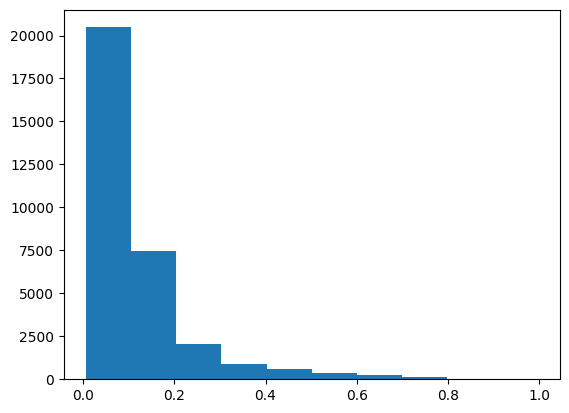

In [47]:
# Check the distribution of predicted probabilities.
plt.hist(probabilities_logistic_l2)

In [48]:
# Find optimal threshold for logistic regression
N = len(training_df)
thresholds = np.linspace(0, 1, 101)  # Define a range of possible thresholds
optimal_payoff = -np.inf
optimal_threshold_logistic_l2 = None
actual = training_df["Default"]

for threshold in thresholds:
    # Vectorized calculation of classifications based on the current threshold
    predictions = (probabilities_logistic_l2 > threshold).astype(float)

    # Vectorized calculation of payoffs
    TP = (predictions == 1) & (actual == 1)
    TN = (predictions == 0) & (actual == 0)
    FP = (predictions == 1) & (actual == 0)
    FN = (predictions == 0) & (actual == 1)

    # Calculate total expected payoff for the current threshold
    current_payoff = np.sum(training_df['payoff_TP'][TP]) + \
     np.sum(training_df['payoff_TN'][TN]) + \
     np.sum(training_df['payoff_FP'][FP]) + \
     np.sum(training_df['payoff_FN'][FN])

    # Update optimal threshold if the current threshold yields a higher payoff
    if current_payoff > optimal_payoff:
        optimal_payoff = current_payoff
        optimal_threshold_logistic_l2 = threshold

print(f"Optimal Threshold: {optimal_threshold_logistic_l2}, Optimal Payoff: {optimal_payoff/N}")

Optimal Threshold: 0.21, Optimal Payoff: 514.4084135338346


In [49]:
# Prediction to the testing set
probabilities_logistic__l2_test = model_logistic_l2.predict_proba(X_stepwise_test)[:, 1]  # Get the probability of the positive class
# Use the threshold from training set to carry out classification
predicted_test_logistic_l2 = (probabilities_logistic__l2_test > optimal_threshold_logistic_l2).astype(int)

In [50]:
accuracy_logistic = accuracy_score(y_stepwise_test, predicted_test_logistic_l2)
accuracy_logistic

0.792722547108512

In [52]:
predicted_test_logistic_l2.sum()

1348

In [54]:
# Calculate payoff for training set
actual = testing_df["Default"]
N = len(testing_df)

# Vectorized calculation of payoffs
TP = (predicted_test_logistic_l2 == 1) & (actual == 1)
TN = (predicted_test_logistic_l2 == 0) & (actual == 0)
FP = (predicted_test_logistic_l2 == 1) & (actual == 0)
FN = (predicted_test_logistic_l2 == 0) & (actual == 1)

# Calculate total expected payoff for the current threshold
payoff_logistic_l2 = (np.sum(testing_df['payoff_TP'][TP]) + \
  np.sum(testing_df['payoff_TN'][TN]) + \
  np.sum(testing_df['payoff_FP'][FP]) + \
  np.sum(testing_df['payoff_FN'][FN]))/N
payoff_logistic_l2

541.7369068226122